In [1]:
import keras
import warnings
import numpy as np
import pandas as pd
from math import sqrt
import pmdarima as pm
import statsmodels.api as sm
from fbprophet import Prophet
from numpy import concatenate
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
from keras.models import Sequential
from statsmodels.tsa.api import VAR
from keras.layers import LSTM, Dense
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from pmdarima.model_selection import train_test_split
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

warnings.filterwarnings("ignore")

## Dataset

In [2]:
df = pd.read_csv('zillow-carlifornia.csv', index_col='Date', parse_dates=True)
df = df[:'2015-12-31']
df.head()

,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
Date,,,
2008-02-29,470000.0,5.29,6.3
2008-03-31,441000.0,5.44,6.2
2008-04-30,460000.0,5.42,6.4
2008-05-31,429000.0,5.47,6.3
2008-06-30,437500.0,5.60,6.2


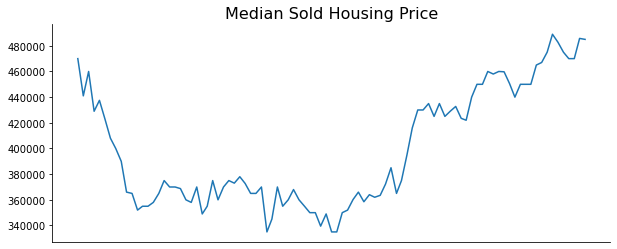

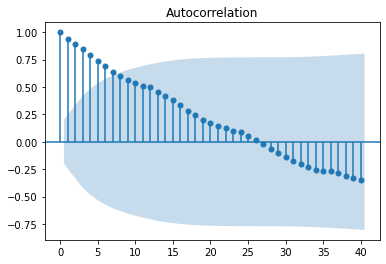

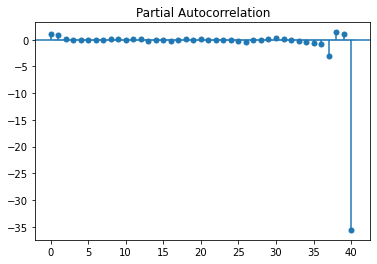

In [3]:
series = df['MedianSoldPrice_AllHomes.California']
x = np.array(series)
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.plot(series)
plt.title('Median Sold Housing Price', size=16)
plt.show()
plot_acf(series, lags=40)
plt.show()
plot_pacf(series, lags=40)
plt.show()

# Univariate Analysis

## SARIMA

In [4]:
dftest = adfuller(series)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic', 'p-value'])
print(dfoutput)

Test Statistic   -0.058792
p-value           0.953391
dtype: float64


In [5]:
def diff(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff
# trend differencing

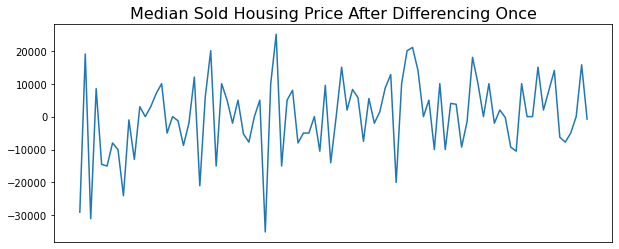

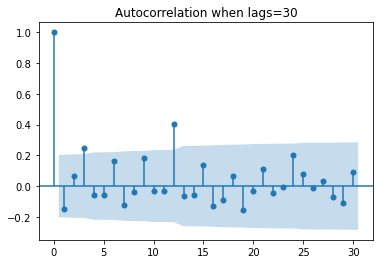

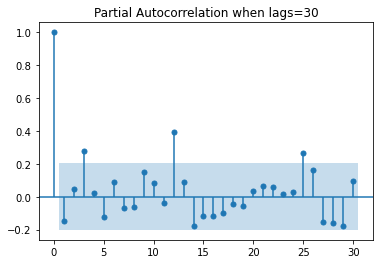

In [6]:
# differencing once
d1 = diff(series, 1)
fig = plt.figure(figsize=(10, 4))
plt.plot(d1)
plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('Median Sold Housing Price After Differencing Once', size=16)
plt.show()
plot_acf(d1, lags=30)
plt.title('Autocorrelation when lags=30')
plt.show()
plot_pacf(d1, lags=30)
plt.title('Partial Autocorrelation when lags=30')
plt.show()
# flat already

In [7]:
dftest = adfuller(d1)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic', 'p-value'])
print(dfoutput)

Test Statistic   -3.088139
p-value           0.027443
dtype: float64


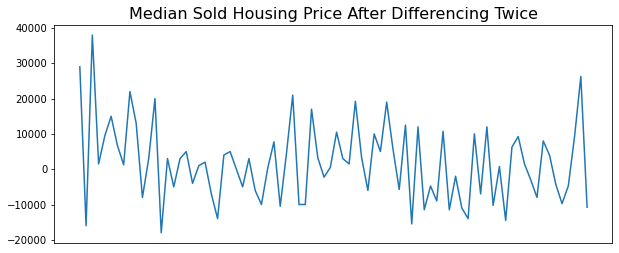

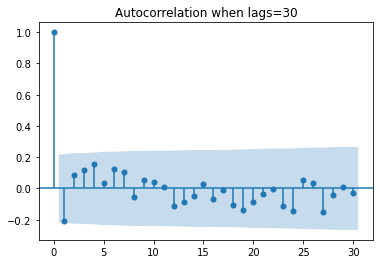

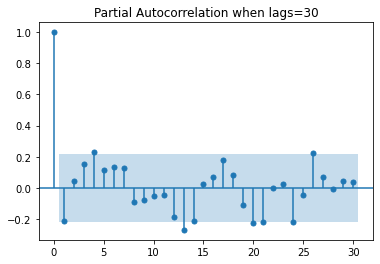

Test Statistic   -1.137508e+01
p-value           8.786119e-21
dtype: float64


In [8]:
# if differencing for one more time
d2 = diff(d1, 12)
fig = plt.figure(figsize=(10, 4))
plt.plot(d2)
plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('Median Sold Housing Price After Differencing Twice', size=16)
plt.show()
plot_acf(d2, lags=30)
plt.title('Autocorrelation when lags=30')
plt.show()
plot_pacf(d2, lags=30)
plt.title('Partial Autocorrelation when lags=30')
plt.show()
dftest = adfuller(d2)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic', 'p-value'])
print(dfoutput)

In [9]:
y_train = df['MedianSoldPrice_AllHomes.California']

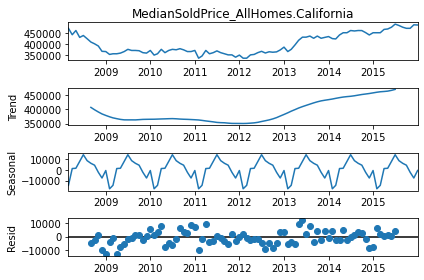

In [10]:
# Decompose to check trend and seasonality
%matplotlib inline
res = sm.tsa.seasonal_decompose(series, freq=12, model="additive")
fig = res.plot()
plt.show()

In [11]:
# seasonality = 7
sarima_house = pm.auto_arima(y_train,
                             information_criterion='bic',
                             out_of_sample_size=int(len(df)*0.2),
                             test='adf',
                             start_p=1, start_q=1,
                             max_p=5, max_q=5, m=7,
                             max_P=5, max_Q=5,
                             seasonal=True,
                             d=1, max_d=2,
                             D=1, trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

Performing stepwise search to minimize bic
 ARIMA(1,1,1)(1,1,1)[7]             : BIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,1,0)[7]             : BIC=1944.572, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[7]             : BIC=1946.383, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[7]             : BIC=1945.388, Time=0.06 sec
 ARIMA(0,1,0)(1,1,0)[7]             : BIC=1946.093, Time=0.07 sec
 ARIMA(0,1,0)(0,1,1)[7]             : BIC=1943.119, Time=0.05 sec
 ARIMA(0,1,0)(1,1,1)[7]             : BIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,1,2)[7]             : BIC=1946.475, Time=0.15 sec
 ARIMA(0,1,0)(1,1,2)[7]             : BIC=inf, Time=0.26 sec
 ARIMA(1,1,0)(0,1,1)[7]             : BIC=1945.833, Time=0.06 sec
 ARIMA(1,1,1)(0,1,1)[7]             : BIC=1945.962, Time=0.12 sec
 ARIMA(0,1,0)(0,1,1)[7] intercept   : BIC=1948.812, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,1,1)[7]          
Total fit time: 1.472 seconds


In [12]:
# seasonality = 12
sarima_house = pm.auto_arima(y_train,
                             information_criterion='bic',
                             out_of_sample_size=int(len(df)*0.1),
                             test='adf',
                             start_p=1, start_q=1,
                             max_p=5, max_q=5, m=12,
                             max_P=5, max_Q=5,
                             seasonal=True,
                             d=1, max_d=12,
                             D=2, trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

Performing stepwise search to minimize bic
 ARIMA(1,1,1)(1,2,1)[12]             : BIC=1534.936, Time=0.31 sec
 ARIMA(0,1,0)(0,2,0)[12]             : BIC=1559.381, Time=0.03 sec
 ARIMA(1,1,0)(1,2,0)[12]             : BIC=1564.406, Time=0.12 sec
 ARIMA(0,1,1)(0,2,1)[12]             : BIC=1527.654, Time=0.15 sec
 ARIMA(0,1,1)(0,2,0)[12]             : BIC=1562.472, Time=0.05 sec
 ARIMA(0,1,1)(1,2,1)[12]             : BIC=1530.830, Time=0.22 sec
 ARIMA(0,1,1)(0,2,2)[12]             : BIC=1530.353, Time=0.49 sec
 ARIMA(0,1,1)(1,2,0)[12]             : BIC=1564.541, Time=0.12 sec
 ARIMA(0,1,1)(1,2,2)[12]             : BIC=inf, Time=0.97 sec
 ARIMA(0,1,0)(0,2,1)[12]             : BIC=inf, Time=0.20 sec
 ARIMA(1,1,1)(0,2,1)[12]             : BIC=1531.874, Time=0.22 sec
 ARIMA(0,1,2)(0,2,1)[12]             : BIC=1533.075, Time=0.17 sec
 ARIMA(1,1,0)(0,2,1)[12]             : BIC=inf, Time=0.30 sec
 ARIMA(1,1,2)(0,2,1)[12]             : BIC=1536.619, Time=0.27 sec
 ARIMA(0,1,1)(0,2,1)[12] intercept

In [13]:
sarima_house = pm.auto_arima(y_train,
                             information_criterion='bic',
                             out_of_sample_size=int(len(df)*0.1),
                             test='adf',
                             start_p=1, start_q=1,
                             max_p=5, max_q=5, m=12,
                             max_P=5, max_Q=5,
                             seasonal=True,
                             d=0, max_d=12,
                             D=2, trace=True,
                             error_action='ignore',
                             with_intercept=True,
                             suppress_warnings=True,
                             stepwise=True)

Performing stepwise search to minimize bic
 ARIMA(1,0,1)(1,2,1)[12] intercept   : BIC=1561.874, Time=0.37 sec
 ARIMA(0,0,0)(0,2,0)[12] intercept   : BIC=1714.730, Time=0.03 sec
 ARIMA(1,0,0)(1,2,0)[12] intercept   : BIC=1731.394, Time=0.21 sec
 ARIMA(0,0,1)(0,2,1)[12] intercept   : BIC=1672.931, Time=0.34 sec
 ARIMA(0,0,0)(0,2,0)[12]             : BIC=1718.386, Time=0.02 sec
 ARIMA(1,0,1)(0,2,1)[12] intercept   : BIC=inf, Time=0.61 sec
 ARIMA(1,0,1)(1,2,0)[12] intercept   : BIC=1737.245, Time=0.22 sec
 ARIMA(1,0,1)(2,2,1)[12] intercept   : BIC=1565.253, Time=1.50 sec
 ARIMA(1,0,1)(1,2,2)[12] intercept   : BIC=inf, Time=1.38 sec
 ARIMA(1,0,1)(0,2,0)[12] intercept   : BIC=1667.304, Time=0.39 sec
 ARIMA(1,0,1)(0,2,2)[12] intercept   : BIC=1561.925, Time=0.59 sec
 ARIMA(1,0,1)(2,2,0)[12] intercept   : BIC=1620.810, Time=0.59 sec
 ARIMA(1,0,1)(2,2,2)[12] intercept   : BIC=1566.352, Time=1.48 sec
 ARIMA(0,0,1)(1,2,1)[12] intercept   : BIC=1686.502, Time=0.42 sec
 ARIMA(1,0,0)(1,2,1)[12] inte

In [14]:
# model evaluation based on RMSE and one-step cross validation
def rmse_sarima(X, trend_order, seasonal_order, split_size):  # added split_size
    train_size = int(len(X) * split_size)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = sm.tsa.statespace.SARIMAX(
            history, order=trend_order, seasonal_order=seasonal_order)
        res = model.fit()
        yhat = res.predict(start=len(history), end=len(
            history))  # predict one step
        predictions.append(yhat)  # store prediction
        history.append(test[t])  # store observation
        # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [15]:
split_size = 0.67
X = df['MedianSoldPrice_AllHomes.California']

sarima_rmse1 = rmse_sarima(X, (2, 1, 2), (0, 1, 0, 12), split_size)
sarima_rmse2 = rmse_sarima(X, (1, 0, 0), (0, 2, 2, 12), split_size)
sarima_rmse3 = rmse_sarima(X, (0, 1, 1), (0, 2, 1, 12), split_size)
sarima_rmse4 = rmse_sarima(X, (1, 0, 1), (0, 2, 1, 12), split_size)

In [16]:
print(sarima_rmse1)  # Sarima Choice
print(sarima_rmse2)
print(sarima_rmse3)
print(sarima_rmse4)

9945.05743566994
11080.336434490742
12751.057628041412
10934.825700116724


## ETS

In [17]:
def evaluate_es_model(X, Trend, Seasonal, m, damped):
    train_size = int(len(X) * 0.90)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ExponentialSmoothing(
            history, trend=Trend, seasonal=Seasonal, seasonal_periods=m, damped=damped)
        res = model.fit()
        yhat = res.forecast()[0]  # predict one step
        predictions.append(yhat)  # store prediction
        history.append(test[t])  # store observation
        # calculate out of sample error
    rmse = mean_squared_error(test, predictions, squared=False)
    return rmse

In [18]:
X = np.array(df['MedianSoldPrice_AllHomes.California']) + \
    1  # adding 1 to avoide 0 consumption
ets_rmse_1 = evaluate_es_model(
    X, Trend="additive", Seasonal="additive", m=12, damped=True)
ets_rmse_2 = evaluate_es_model(
    X, Trend="multiplicative", Seasonal="additive", m=12, damped=True)
ets_rmse_3 = evaluate_es_model(
    X, Trend="additive", Seasonal="multiplicative", m=12, damped=True)
ets_rmse_4 = evaluate_es_model(
    X, Trend="multiplicative", Seasonal="multiplicative", m=12, damped=True)
ets_rmse_5 = evaluate_es_model(
    X, Trend=None, Seasonal="additive", m=12, damped=False)
ets_rmse_6 = evaluate_es_model(
    X, Trend=None, Seasonal="multiplicative", m=12, damped=False)
ets_rmse_7 = evaluate_es_model(
    X, Trend="multiplicative", Seasonal="multiplicative", m=12, damped=False)

In [19]:
print(ets_rmse_1)
print(ets_rmse_2)
print(ets_rmse_3) # best on jupyter notebook
print(ets_rmse_4) # best on deepnote
print(ets_rmse_5)
print(ets_rmse_6)
print(ets_rmse_7)

9405.877290838258
9423.423145932229
9224.38980666362
1.6845552338904464e+53
9737.829030929199
9534.832017902767
9550.564293915997


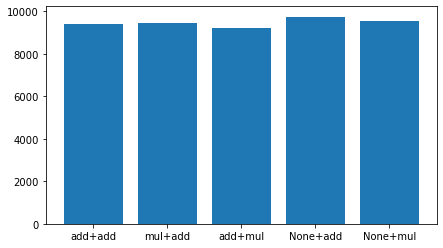

In [20]:
data = {'add+add': ets_rmse_1, 'mul+add': ets_rmse_2, 'add+mul': ets_rmse_3,
        'None+add': ets_rmse_5, 'None+mul': ets_rmse_6}
models = list(data.keys())
rmse = list(data.values())
plt.figure(figsize=(7, 4))
plt.bar(models, rmse)
plt.show()

## Prophet

In [21]:
df['ds'] = df.index
dt = df[['ds', 'MedianSoldPrice_AllHomes.California']]
dt = dt.rename(columns={"MedianSoldPrice_AllHomes.California": "y"})
dt.tail()

,ds,y
Date,,
2015-08-31,2015-08-31,475000.0
2015-09-30,2015-09-30,470000.0
2015-10-31,2015-10-31,470000.0
2015-11-30,2015-11-30,485750.0
2015-12-31,2015-12-31,485000.0


In [22]:
prediction_size = 12
train_df = dt[:-prediction_size]
val_df = dt[-prediction_size:]
train_df.tail()

,ds,y
Date,,
2014-08-31,2014-08-31,460000.0
2014-09-30,2014-09-30,459750.0
2014-10-31,2014-10-31,450500.0
2014-11-30,2014-11-30,440000.0
2014-12-31,2014-12-31,450000.0


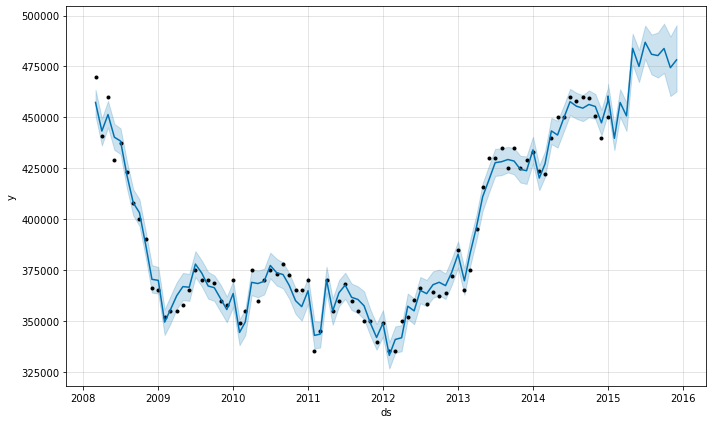

In [56]:
m = Prophet(weekly_seasonality=True, daily_seasonality=False)
m.fit(train_df)

future = m.make_future_dataframe(periods=prediction_size, freq='MS')
forecast = m.predict(future)

m.plot(forecast).show()

In [24]:
pred = forecast["yhat"][train_df.shape[0]:]

In [25]:
prophet_rmse = mean_squared_error(val_df['y'], pred, squared=False)
print(prophet_rmse)

10575.156528677106


## LSTM

In [26]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        return agg

In [ ]:
values = df['MedianSoldPrice_AllHomes.California'].values.reshape(-1, 1)
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
# print(reframed.head())
values = reframed.values
period = 12
train = values[:-period, :]
test = values[-period:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
# the 4 is the number of hidden layers/neurons, proportional to the sample size
model.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))  # final fully-connected (dense) layer, optional
model.compile(loss='mse')
# fit network
history = model.fit(train_X, train_y, epochs=200,
                    batch_size=7, validation_data=(test_X, test_y))

In [28]:
from numpy import concatenate
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

lstm_rmse = mean_squared_error(
    np.array(inv_y), np.array(inv_yhat), squared=False)
print(lstm_rmse)

10838.570001947022


In [29]:
univariate = pd.DataFrame()
univariate['Univariate'] = ['SARIMA', 'ETS', 'Prophet', 'LSTM']
univariate['RMSE'] = [round(sarima_rmse1), round(ets_rmse_3),
                      round(prophet_rmse), round(lstm_rmse)]
univariate.set_index('Univariate')

,RMSE
Univariate,
SARIMA,9945.0
ETS,9224.0
Prophet,10575.0
LSTM,10839.0


# Multivariate Analysis

In [30]:
zillow = pd.read_csv('zillow-carlifornia.csv', index_col=[0], parse_dates=True)
df = zillow[:'2015-12-31']
df_diff = df.diff().dropna()
df_diff.head()

,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
Date,,,
2008-03-31,-29000.0,0.15,-0.1
2008-04-30,19000.0,-0.02,0.2
2008-05-31,-31000.0,0.05,-0.1
2008-06-30,8500.0,0.13,-0.1
2008-07-31,-14500.0,0.31,-0.6


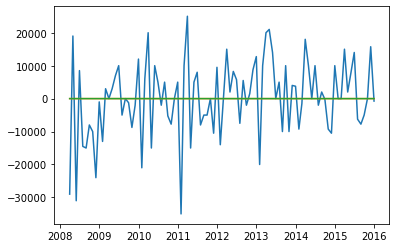

In [31]:
plt.plot(df_diff)
plt.show()

## VAR

In [32]:
model = VAR(df_diff)
results = model.fit(maxlags=15, ic='bic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 13, Jun, 2021
Time:                     02:15:00
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    14.1741
Nobs:                     94.0000    HQIC:                   14.1257
Log likelihood:          -1059.51    FPE:                1.31969e+06
AIC:                      14.0929    Det(Omega_mle):     1.27845e+06
--------------------------------------------------------------------
Results for equation MedianSoldPrice_AllHomes.California
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const       159.574468      1194.380592            0.134           0.894

Results for equation MedianMortageRate
           coefficient       std. error           t-stat            prob
----------------------

In [33]:
model = VAR(df)
results = model.fit(maxlags=15, ic='bic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 13, Jun, 2021
Time:                     02:15:00
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    14.1471
Nobs:                     94.0000    HQIC:                   13.9536
Log likelihood:          -1037.80    FPE:                1.00710e+06
AIC:                      13.8224    Det(Omega_mle):         888750.
--------------------------------------------------------------------
Results for equation MedianSoldPrice_AllHomes.California
                                            coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------------------
const                                      28600.710790     23166.335094            1.235           0.217
L1.MedianSoldPrice_AllHomes.Californ

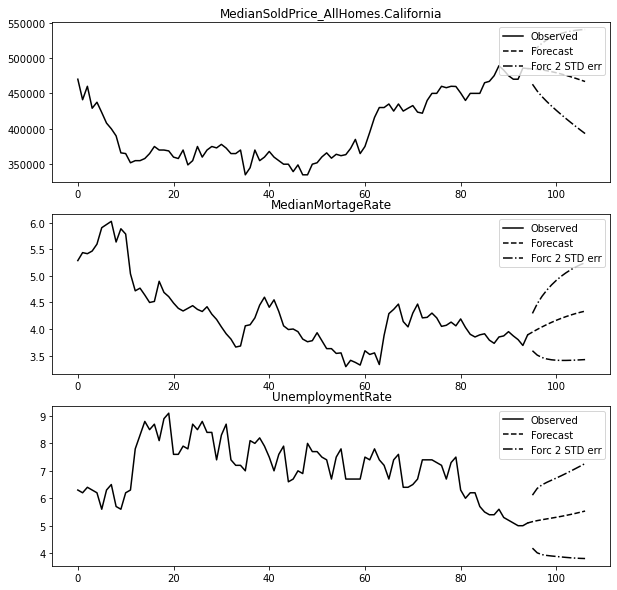

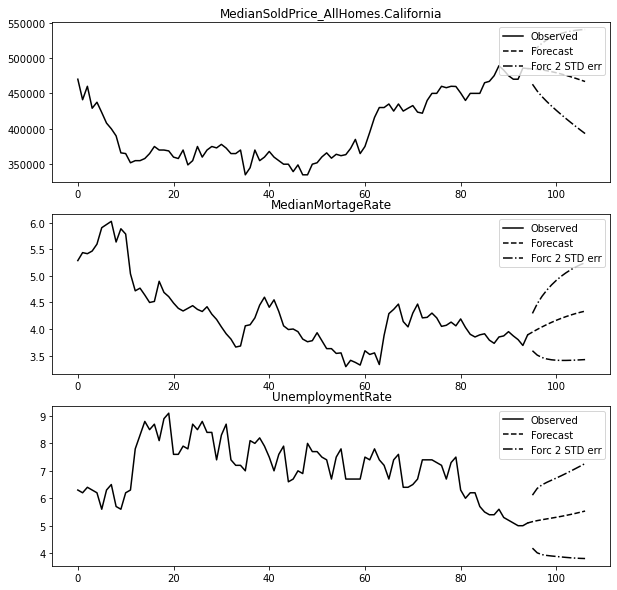

In [34]:
results.plot_forecast(12)

## Prophet

In [35]:
df['ds'] = df.index
df = df.rename(columns={"MedianSoldPrice_AllHomes.California": "y"})
dt = df[['ds', 'y', 'UnemploymentRate']].dropna()
dt2 = df[['ds', 'y', 'MedianMortageRate']].dropna()
dt3 = df[['ds', 'y', 'MedianMortageRate', 'UnemploymentRate']].dropna()

In [36]:
prediction_size = 12
train_df = dt2[:-prediction_size]
val_df = dt2[-prediction_size:]
train_df.tail()

,ds,y,MedianMortageRate
Date,,,
2014-08-31,2014-08-31,460000.0,4.13
2014-09-30,2014-09-30,459750.0,4.06
2014-10-31,2014-10-31,450500.0,4.19
2014-11-30,2014-11-30,440000.0,4.03
2014-12-31,2014-12-31,450000.0,3.90


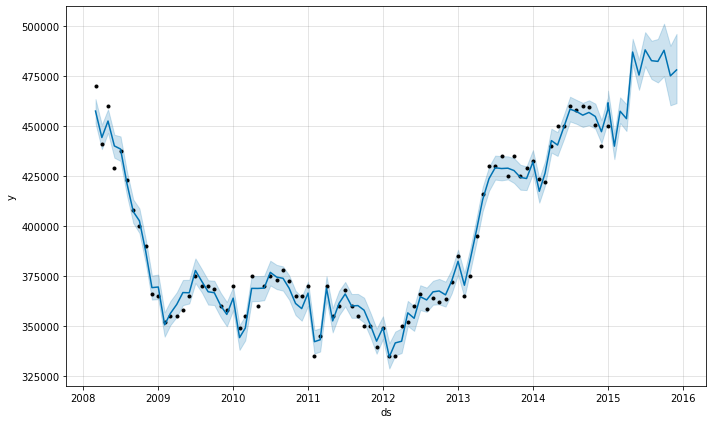

In [37]:
m = Prophet(weekly_seasonality=True, daily_seasonality=False)

m.add_regressor('MedianMortageRate')
m.fit(train_df)

future = m.make_future_dataframe(periods=prediction_size, freq='MS')
future['MedianMortageRate'] = dt2['MedianMortageRate'].values
forecast = m.predict(future)
m.plot(forecast).show()

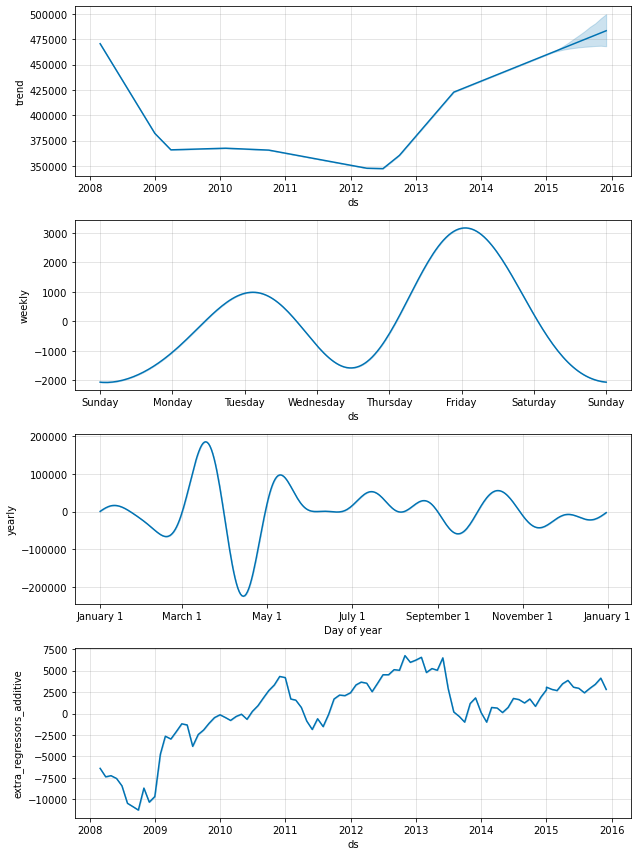

In [38]:
m.plot_components(forecast).show()

In [39]:
pred = forecast["yhat"][train_df.shape[0]:]

In [40]:
multi_prophet_rmse = mean_squared_error(val_df['y'], pred, squared=False)
print(multi_prophet_rmse)

11248.882550106793


 - dt_rmse = 14292.82195 # Unemployment Rate as regressor
 - dt2_rmse = 9858.86538 # Median Morgage Rate as regressor
 - dt3_rmse = 13124.48921 # Both as regressors

## SARIMAX

In [41]:
zillow = pd.read_csv('zillow-carlifornia.csv', index_col=[0], parse_dates=True)
df = zillow[:'2015-12-31']

prediction_size = 12
train = df[:-prediction_size]
valid = df[-prediction_size:]
# train_df.head()

In [42]:
sc = MinMaxScaler(feature_range=(0, 1))
train_sc = sc.fit_transform(train)
test_sc = sc.transform(valid)
model = auto_arima(train_sc[:, 0],  # gdp as endogenous
                   exogenous=train_sc[:, 1:],  # rest as exogenous
                   start_p=0, start_q=0,
                   max_p=4, max_q=4,
                   max_d=2,
                   m=12, D=1, max_P=3, max_Q=3,
                   trace=True,
                   error_action='ignore',
                   with_intercept=True,
                   suppress_warnings=True,
                   information_criterion='oob',
                   n_jobs=-1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12] intercept   : AIC=-147.088, Time=0.40 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=-144.484, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AIC=-148.827, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=-149.683, Time=0.38 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-144.310, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=-145.555, Time=0.14 sec
 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=-148.768, Time=0.46 sec
 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(0,1,1)(1,1,0)[12] intercept   : AIC=-145.893, Time=0.29 sec
 ARIMA(0,1,1)(1,1,2)[12] intercept   : AIC=-148.932, Time=1.06 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=-145.127, Time=0.27 sec
 ARIMA(1,1,1)(0,1,1)[12] intercept   : AIC=-154.120, Time=0.43 sec
 ARIMA(1,1,1)(0,1,0)[12] intercept   : AIC=-146.630, Time=0.23 sec
 ARIMA(1,1,1)(1,1,1)[12] intercept   : AIC=-143.681, Time=0.52 sec
 ARIMA(1,1,1)(0,1,2)[12]

In [43]:
y_pred = model.predict(n_periods=prediction_size,
                       X=test_sc[:, 1:]).reshape(-1, 1)
y_pred_ = np.repeat(y_pred, 3, axis=1)
# inverset the pred and take the first column (gdp)
y_pred_inv = sc.inverse_transform(y_pred_)[:, 0]

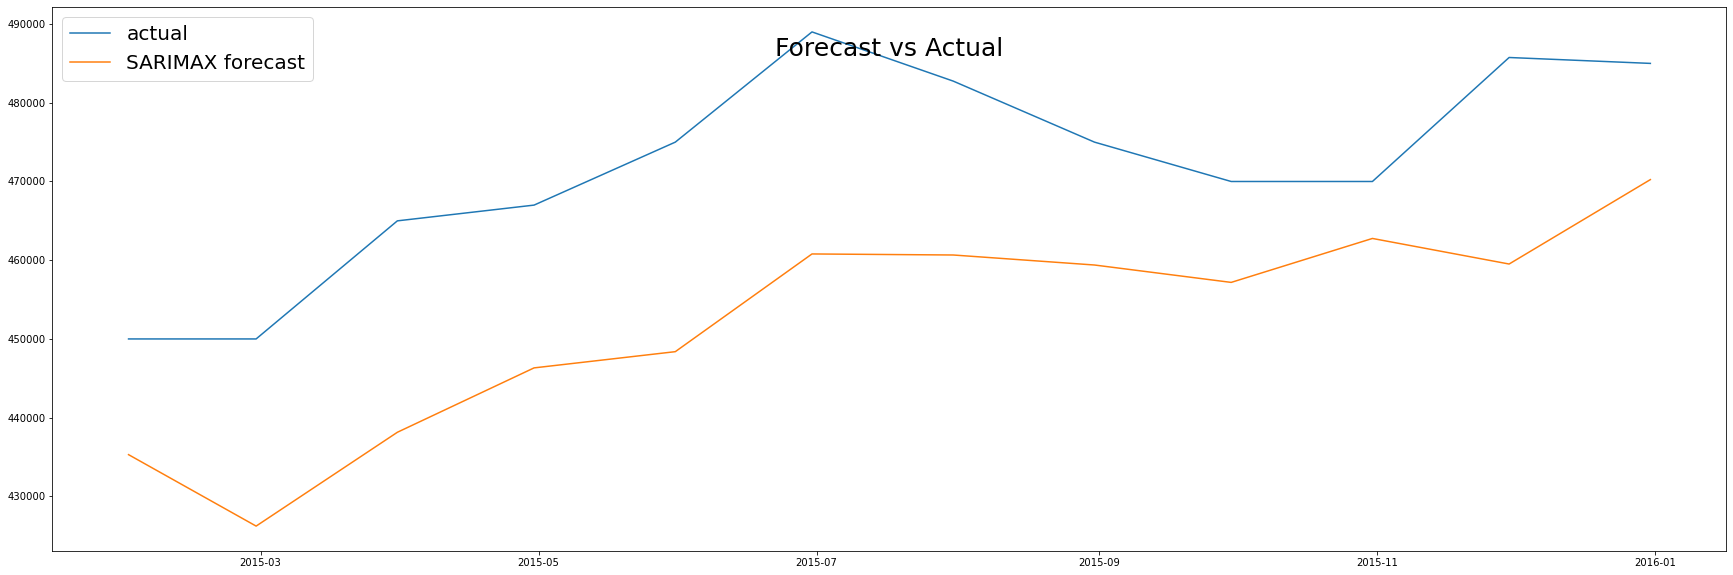

In [44]:
y_pred_series = pd.Series(y_pred_inv, index=valid.index)
plt.figure(figsize=(30, 10))

plt.plot(valid['MedianSoldPrice_AllHomes.California'], label='actual')
plt.plot(y_pred_series, label='SARIMAX forecast')
plt.legend(loc='upper left', fontsize=20)
plt.title('Forecast vs Actual', fontsize=25, y=0.9)
plt.show()

In [45]:
sarimax_rmse = mean_squared_error(
    y_pred_series, valid['MedianSoldPrice_AllHomes.California'], squared=False)
print(sarimax_rmse)

20992.153734202082


## LSTM

In [ ]:
values = df[['MedianSoldPrice_AllHomes.California', 'UnemploymentRate']].values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[-1]], axis=1, inplace=True)
values = reframed.values
period = 12
train = values[:-period, :]
test = values[-period:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# design network
model = Sequential()
# the 4 is the number of hidden layers/neurons, proportional to the sample size
model.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))  # final fully-connected (dense) layer, optional
model.compile(loss='mse')
# fit network
history = model.fit(train_X, train_y, epochs=200,
                    batch_size=7, validation_data=(test_X, test_y))

In [47]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

multi_lstm_rmse = mean_squared_error(
    np.array(inv_y), np.array(inv_yhat), squared=False)
print(multi_lstm_rmse)

18254.606228334185


In [48]:
multivariate = pd.DataFrame()
multivariate['Multivariate'] = ['Prophet', 'SARIMA', 'LSTM']
multivariate['RMSE'] = [round(multi_prophet_rmse), round(sarimax_rmse),
                        round(multi_lstm_rmse)]
multivariate.set_index('Multivariate')

,RMSE
Multivariate,
Prophet,11249.0
SARIMA,20992.0
LSTM,18255.0


In [49]:
# testing model on test.csv
test = pd.read_csv('test.csv', index_col=[0], parse_dates=True)
print(test)

            Median House Price
Month                         
2016-01-31              476250
2016-02-29              466000
2016-03-31              485000
2016-04-30              501000
2016-05-31              501000
2016-06-30              505000
2016-07-31              507000
2016-08-31              510000
2016-09-30              510000
2016-10-31              523000
2016-11-30              506000
2016-12-31              510000


In [50]:
# Fit best model on entire train data and then forecast
Trend = 'multiplicative'
Seasonal = "multiplicative"
m = 12
Damped = True
X = np.array(df['MedianSoldPrice_AllHomes.California']) + \
    1  # adding 1 to avoid 0 sales
best_model_ets = ExponentialSmoothing(
    X, trend=Trend, seasonal=Seasonal, damped=Damped, seasonal_periods=m)
pred_best_ets = best_model_ets.fit().forecast(len(test))
pred_best_ets

array([481146.47489458, 475019.56962894, 487157.2058137 , 489736.51821274,
       495728.09144304, 506054.07033965, 498533.04324648, 492821.60728182,
       491998.57370457, 491791.79851053, 500494.2309769 , 502535.8369324 ])

In [51]:
mean_squared_error(test, pred_best_ets, squared=False)

12963.309410446729

In [52]:
mean_absolute_percentage_error(test, pred_best_ets)

0.02000372840200307

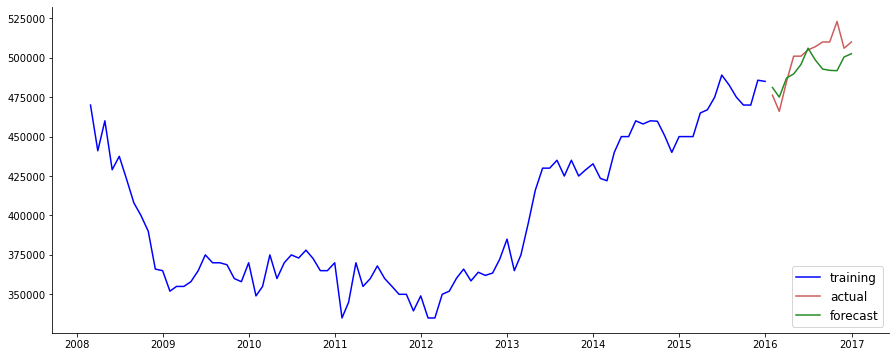

In [53]:
test['prediction'] = pred_best_ets
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(df['MedianSoldPrice_AllHomes.California'],
        label='training', color='blue')
ax.plot(test['Median House Price'], label='actual', color='indianred')
ax.plot(test['prediction'], label='forecast', color='forestgreen')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(loc='lower right', fontsize=12)
plt.show()

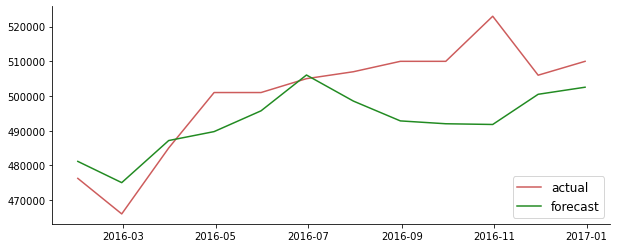

In [54]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(test['Median House Price'], label='actual', color='indianred')
ax.plot(test['prediction'], label='forecast', color='forestgreen')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(loc='lower right', fontsize=12)
plt.show()

In [55]:
test['prediction'] = test['prediction'].apply(round)
test

,Median House Price,prediction
Month,,
2016-01-31,476250,481146
2016-02-29,466000,475020
2016-03-31,485000,487157
2016-04-30,501000,489737
2016-05-31,501000,495728
2016-06-30,505000,506054
2016-07-31,507000,498533
2016-08-31,510000,492822
2016-09-30,510000,491999
